In [0]:
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.linalg import expm
import matplotlib.pyplot as plt

# Recreating ugvmpc.m script

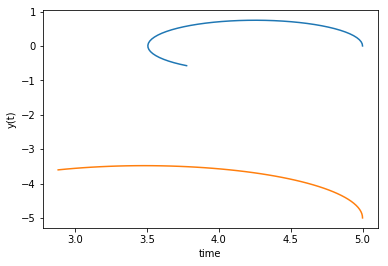

In [0]:
#POC recreating the script
def ugvModel(x,t,u):
  L=0.2; #Length of wheel base in meters
  dx=[0.,0.,0.];
  dx[0]=u[0]*np.cos(x[2]);
  dx[1]=u[0]*np.sin(x[2]);
  dx[2]=u[0]/L*np.tan(u[1]);
  return dx

# initial condition
x01 = [5,0,np.pi/2]
x02 = [5,-5,np.pi/2]

# time points
t = np.linspace(0,1)
u1 = [3,np.pi/12]
u2 = [3,np.pi/24]
# solve ODE
y1 = integrate.odeint(ugvModel,x01,t,args=(u1,))
y2 = integrate.odeint(ugvModel,x02,t,args=(u2,))

y1=y1.T
y2=y2.T
# plot results
plt.plot(y1[0][:],y1[1][:])
plt.plot(y2[0][:],y2[1][:])
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

# Model Predictive Control
---
$$ A_d=e^{A_ct}$$
$$ B_d=\int_{0}^{T_s}e^{A_c\tau}d\tau \cdot B_c $$
$$ C_d=C_c $$
$$ \Phi_a=
\begin{bmatrix}
  A_d  & 0 \\ 
  C_dA_d & I_p
\end{bmatrix}$$
$$\Gamma_a=
\begin{bmatrix}
B_d \\
C_dB_d
\end{bmatrix}$$
$$C_a=
\begin{bmatrix}
0_{pxn} & I_p
\end{bmatrix}$$
$$W=
\begin{bmatrix}
C_a\Phi_a \\
C_a\Phi_a^2 \\
C_a\Phi_a^3 \\
\vdots \\
C_a\Phi_a^{N_p}
\end{bmatrix}$$
$$Z=
\begin{bmatrix}
C_a & 0 & 0 & \dots & 0 \\
C_a\Phi_a & Ca & 0 & \dots &0 \\
C_a\Phi_a^2 & C_a\Phi_a & C_a & \dots &0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
C_a\Phi_a^{N_p-1} & C_a\Phi_a^{N_p-2} & C_a\Phi_a^{N_p-3} & \dots & C_a
\end{bmatrix}$$
$$Y_a=Wx_a+Z\Delta U$$

$$ Minimize \hspace{1cm} J(\Delta U)=Y^TQY+\Delta U^TR\Delta U $$
$$ s.t.:\hspace{1cm} |U|\leq 0.5 rads$$
$$\hspace{2cm} |\Delta U|\leq 0.1 rads$$


In [0]:
class pid:
  def __init__(self,Kp,Ti,Td,N,h):
    self.h=h
    self.Kp=Kp
    self.Ti=Ti
    self.Td=Td
    self.N=N
    self.ad=Td/(N*self.h+Td)
    self.bd=N*Kp*self.ad
    self.eold=0.
    self.Dold=0.
    self.Iold=0.
    
  def calc(self,r,x):
    #Only feed current x
    N=100
    beta=np.arctan2(x[4]-x[1],x[3]-x[0])
    e = np.mod((beta-x[5]),2*np.pi)-np.pi
    P = self.Kp*e;
    I = self.Iold;
    D = self.ad*self.Dold+self.bd*(self.eold-e); 
    self.Iold = self.Iold + self.Kp*self.h/self.Ti*e;
    self.Dold = D;
    self.eold = e;
    return P+I+D  
  
class MPC:
  def __init__(self,L,h,Np,Q,R):
    self.L=L
    self.h=h
    self.Np=Np
    diagQ=np.kron(np.eye(self.Np),Q)
    diagR=np.kron(np.eye(self.Np),R)
    self.Q=diagQ
    self.R=diagR
  
  def cost(self,du,W,Z):
    np.zeros([3,1],dtype="float64")
    ref=np.kron(r,np.ones([self.Np,1]))
    return 0.5*((ref-W.dot(self.xa)-Z.dot(du)).T.dot(self.Q).dot(ref-W.dot(self.xa)-Z.dot(du))+du.T.dot(self.R).dot(du))
  
  def mpcMats(self,Ac,Bc,Cc):
    #Continuous to Discrete Conversion
    Ad=expm(Ac*self.h)
    ieAt=np.empty([6,6])
    for i in range(6):
      for j in range(6):
        ieAt[i,j]=integrate.quad(lambda tau: expm(A*tau)[i,j],0,self.h)[0]
    Bd=ieAt.dot(Bc)
    Cd=Cc
    n=len(Ad)#of states
    m=len(Bd[0])# num of inputs
    p=len(Cd)#of outputs
    #print(n,m,p)
    
    PhiA=np.block([[Ad,np.zeros([n,p])],[Cd.dot(Ad),np.eye(p)]])
    GammaA=np.block([[Bd],[Cd.dot(Bd)]])
    Ca=np.block([np.zeros([p,n]),np.eye(p)])
    W=np.empty([self.Np*p,n+p])
    Z=np.empty([self.Np*p,self.Np*m])
    for i in range(1,self.Np+1):
      W[(i-1)*p:i*p][:]=Ca.dot(np.linalg.matrix_power(PhiA,i))
      for j in range(1,self.Np+1):
        #Only populate lower triangle
        if i>=j:
          #Same diagonal entries are the same so the difference depends on the column versus row (i-j)
          Z[(i-1)*p:i*p,(j-1)*m:j*m]=(Ca.dot(np.linalg.matrix_power(PhiA,i-j))).dot(GammaA)
        
    return(W,Z,Ca,PhiA,GammaA)
  

  
  def optimizer(self,xa,A,B,C,R,Q,r):
    self.xa=xa.reshape([9,1])
    W,Z,Ca,PhiA,GammaA=mpc.mpcMats(A,B,C)
    #diagQ=np.kron(Q,np.eye(Np))
    #diagR=np.kron(R,np.eye(Np))
    diagQ=np.kron(np.eye(self.Np),Q)
    diagR=np.kron(np.eye(self.Np),R)
    ref=np.kron(r,np.ones([self.Np,1]))
#     print("="*30)
#     print("xa",xa.shape)
#     print("R",self.R.shape)
#     print("Q",self.Q.shape)
#     print("Z",Z.shape)
#     print("W",W.shape)
#     print("r",r.shape)
#     print("dQ",diagQ.shape)
#     print("dR",diagR.shape)
#     print("ref",ref.shape)
#     print("dRz'dQz",(diagR+Z.T.dot(diagQ.dot(Z))).shape)
#     print("z'dq",(Z.T.dot(diagQ)).shape)
#     print("refWxa",(ref-W.dot(xa)).shape)
    dummyx0=self.R+Z.T.dot(self.Q).dot(Z)
#     print("x0",dummyx0.shape)
    dummyx1=np.linalg.inv(self.R+Z.T.dot(self.Q.dot(Z)))
#     print("x1",dummyx1.shape)
    dummyx2=dummyx1.dot(Z.T)
#     print("x2",dummyx2.shape)
    dU=dummyx2.dot(self.Q).dot(ref-W.dot(self.xa))
#     print(dU)
#     dU=np.linalg.inv(diagR+Z.T.dot(diagQ).dot(Z)).dot(Z.T).dot(diagQ).dot(ref-W.dot(xa))
    return dU
  
  def ugvModel(self,x,t,u):
    #L=0.2; #Length of wheel base in meters
    dx=np.empty(6);
    dx[0]=u[0]*np.cos(x[2]);
    dx[1]=u[0]*np.sin(x[2]);
    dx[2]=u[0]/self.L*np.tan(u[1]);
    dx[3]=u[2]*np.cos(x[5]);
    dx[4]=u[2]*np.sin(x[5]);
    dx[5]=u[2]/self.L*np.tan(u[3]);
    
    return dx
  
  def ugvJac(self,x,u):
    #Hard-coded analytical Jacobian
    #x[0:2]=UGV1 Pose
    #x[3:5]=UGV2 Pose
    #u[0,2]=Wheel Speed
    #u[1,3]=Steer Angle
    a1=np.array([[0,0,-u[0]*np.sin(x[2])],[0,0,u[0]*np.cos(x[2])],[0,0,0]]) #STMat Sys1
    a2=np.array([[0,0,-u[2]*np.sin(x[5])],[0,0,u[2]*np.cos(x[5])],[0,0,0]]) #STMat Sys2
    b1=np.array([[np.cos(x[2]),0],[np.sin(x[2]),0],[1/self.L*np.tan(u[1]),u[0]/self.L/np.cos(u[1])**2]])#ITMat Sys1
    b2=np.array([[np.cos(x[5]),0],[np.sin(x[5]),0],[1/self.L*np.tan(u[3]),u[2]/self.L/np.cos(u[3])**2]])#ITMat Sys2
    #A=[a1,zeros([3,3]),zeros([3,3]),a2];
    #A=np.stack(np.stack(a1,zeros([3,3]),np.stack(zeros([3,3],a2)),axis=1)
    A=np.block([[a1,np.zeros([3,3])],[np.zeros([3,3]),a2]])
    B=np.block([[b1,np.zeros([3,2])],[np.zeros([3,2]),b2]])
    B=B[:,3].reshape([6,1])
    C=np.block([-1*np.eye(3),np.eye(3)])
    D=[0]
    print("="*30)
    #print(A,B,C,D)
    return (A,B,C,D)

In [0]:
h=0.1
Np=10 #Length of Prediction Horizon
ploss=0.5 #Probability of lost control signal
closs=0  #Number of consecutive losses (caps at 9)

x0=np.array([3.6,0,-np.pi/2,5,0,np.pi/2]).T
u0=np.array([1,np.pi/12,1,0]).T
tspan=[0,20]
xn=np.zeros([6,int(np.ceil(tspan[1]/h+1))])
xn[0:6,0]=x0
xa=np.zeros([9,int(np.ceil(tspan[1]/h+1))])
u=np.kron(np.ones([1,int(np.ceil(tspan[1]/h+1))]),u0.reshape([4,1]))
R=np.diag([0.])
Q=np.diag([400.,400.,0.]) #If I were to impose a cost on theta, it would have to be nonlinear otherwise most initial conditions would throw off the algorithm

mpc=MPC(0.2,h,Np,Q,R)

#pid stuff
control=0
cont=pid(.5,5,.01,100,h)
xn2=xn.copy()
u2=u.copy()

DU=np.zeros([10,1], dtype='float64')
#print(DU)

for k in range(1,int(np.ceil(tspan[1]/h+1))):
  
  #Simulate UGVs for iter
  x=integrate.odeint(mpc.ugvModel,xn[:,k-1],np.linspace((k-1)*h,k*h),args=(u[:,k-1],))
  x2=integrate.odeint(mpc.ugvModel,xn2[:,k-1],np.linspace((k-1)*h,k*h),args=(u2[:,k-1],))
  
  #Calculate Jacobian for AMPC
  A,B,C,D=mpc.ugvJac(xn[:,k-1],u[:,k-1])
  
  #x[-1,2]=np.mod(x[-1,2]+np.pi,np.pi*2)-np.pi
  #x[-1,5]=np.mod(x[-1,5]+np.pi,np.pi*2)-np.pi
  #Value at end of time step
  xn[:,k]=x.T[:,-1]#.reshape([6,1])
  xn2[:,k]=x2.T[:,-1]
  xa[:,k]=np.concatenate(((xn[:,k]-xn[:,k-1]),C.dot(xn[:,k])))
  
  
  #C is setup to automatically take the difference of the poses, so r=<0,0,0>
  r=np.zeros([3,1],dtype="float64")
  event=np.random.rand()
  if event>ploss:
    DU=mpc.optimizer(xa[:,k],A,B,C,R,Q,r)
    control=cont.calc(0,xn2[:,k-1])
    closs=0
    print("Received")
  else:
    closs+=1
    closs=min(closs,Np-1)
    print("Dropped")
  dU=np.min([np.max([DU[closs],-0.1]),0.1])
  u[3,k]=np.min([np.max([dU+u[3,k-1],-0.5]),0.5])
  u2[3,k]=np.min([np.max([control,-0.5]),0.5])
  #print(DU)
print("Done!")


Received
Received
Received
Received
Received
Dropped
Dropped
Received
Dropped
Dropped
Dropped
Dropped
Dropped
Dropped
Received
Dropped
Dropped
Received
Received
Dropped
Received
Dropped
Dropped
Dropped
Received
Received
Dropped
Received
Received
Dropped
Dropped
Received
Received
Received
Received
Dropped
Dropped
Received
Received
Dropped
Received
Dropped
Received
Received
Dropped
Received
Received
Received
Received
Received
Dropped
Received
Received
Received
Received
Dropped
Received
Received
Received
Received
Dropped
Dropped
Dropped
Dropped
Received
Dropped
Dropped
Dropped
Received
Dropped
Received
Received
Dropped
Received
Received
Received
Received
Received
Received
Received
Received
Dropped
Dropped
Dropped
Dropped
Received
Received
Dropped
Dropped
Dropped
Received
Dropped
Received
Dropped
Received
Received
Dropped
Dropped
Dropped
Dropped
Received
Dropped
Dropped
Received
Received
Dropped
Received
Received
Dropped
Received
Received
Received
Received
Dropped
Dropped
Dropped
Dropped
D

(6, 201)
(4, 201)


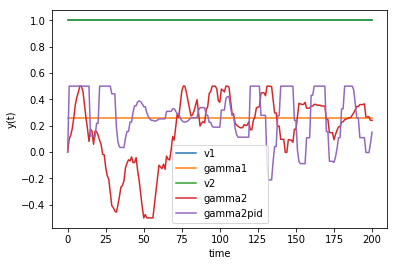

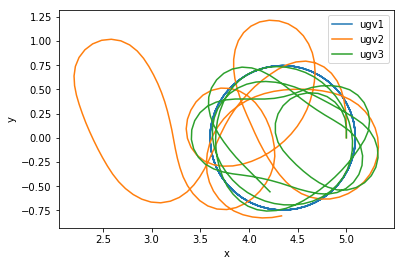

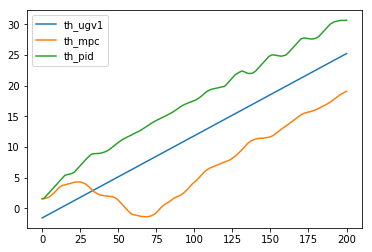

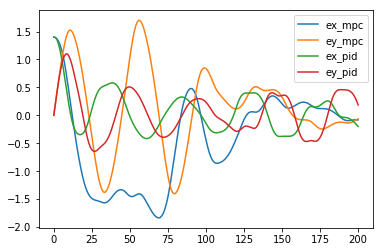

In [0]:
print(xn.shape)
print(u.shape)

#input plot
plt.plot(u[0,:].T,label="v1")
plt.plot(u[1,:].T,label="gamma1")
plt.plot(u[2,:].T,label="v2")
plt.plot(u[3,:].T,label="gamma2")
plt.plot(u2[3,:].T,label="gamma2pid")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

#xy plot
plt.plot(xn[0,:],xn[1,:],label="ugv1")
plt.plot(xn[3,:],xn[4,:],label="ugv2")
plt.plot(xn2[3,:],xn2[4,:],label="ugv3")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# #x plot
# plt.plot(xn[0,:],label="x_ugv1")
# plt.plot(xn[3,:],label="x_mpc")
# plt.plot(xn2[3,:],label="x_pid")
# plt.legend()
# plt.show()

# #y plot
# plt.plot(xn[1,:],label="x_ugv1")
# plt.plot(xn[4,:],label="x_mpc")
# plt.plot(xn2[4,:],label="x_pid")
# plt.legend()
# plt.show()

#theta plot
plt.plot(xn[2,:],label="th_ugv1")
plt.plot(xn[5,:],label="th_mpc")
plt.plot(xn2[5,:],label="th_pid")
plt.legend()
plt.show()

#error plot
plt.plot(xn[3,:]-xn[0,:],label="ex_mpc")
plt.plot(xn[4,:]-xn[1,:],label="ey_mpc")
plt.plot(xn2[3,:]-xn2[0,:],label="ex_pid")
plt.plot(xn2[4,:]-xn2[1,:],label="ey_pid")
plt.legend()
plt.show()

#derivative plot
# plt.plot(xa[6,:],label="dx")
# plt.plot(xa[7,:],label="dy")
# plt.plot(xa[8,:],label="dtheta")
# plt.legend()
# plt.show()

# plt.plot(xn[3,:-1]-xn[3,1:],label="x2mpc")
# plt.plot(xn2[3,:-1]-xn2[3,1:],label="x2pid")
# plt.show()
#print(xn)



# Discussion
---
It seems to me that MPC has better long-term performance overall, though in the short run, pid vastly outperforms it. I think it is because of the fact that the way, by construction, it can actually account for the heading information $x_3$. In order to include something like that for the MPC it would entail the introduction of a nonlinearity. Or I could make the odeint just return an equivalent sort of thing...

In [0]:
print(xn.shape)
print(xa.shape)
print(xn2.shape)
print(np.arctan2(3,4))

(6, 201)
(9, 201)
(6, 201)
0.6435011087932844
